In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import os


In [2]:
# Load the data from the NPZ file from shooting method to validate model
loaded_data = np.load('../shooting_method/data_all.npz')

# Access the arrays using the keys ('r', 'A0', 'alpha0', 'phi0')
r = loaded_data['r']
A_shooting = loaded_data['A0']
alpha_shooting = loaded_data['alpha0']
phi_shooting = loaded_data['phi0']

function to define the nn architecture

In [3]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)

      # Apply custom weight initialization
        self.apply(self._init_weights)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        act = torch.nn.Softplus()
        x = act(x)
        return x

    def _init_weights(self, m):
        if isinstance(m, torch.nn.Linear):
            # Get the size of the previous layer (input size of the current layer)
            n = m.in_features # The number of input features to this layer
            # Set the range for uniform distribution as [-1/sqrt(n), 1/sqrt(n)]
            bound = 1 / np.sqrt(n)
            # Initialize weights with a uniform distribution in the range [-bound, bound]
            torch.nn.init.uniform_(m.weight, -bound, bound)
            
            # Initialize biases to zero, only if the layer has biases
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)

In [4]:
# copied from https://github.com/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

In [5]:
# random (uniform) sample points in (0,1).
def random_domain_points(n):
    #x = torch.rand((n,1), requires_grad=True)
    xhigh = 0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # [0.5,1)
    xlow  = -0.5*torch.rand((int(n/2),1), requires_grad=True) + 0.5 # (0,0.5]
    x = torch.cat((xlow, xhigh),0)
    return x

define the model architecture

In [6]:
#torch.manual_seed(123)

# input 1 (x), output 4 (A, alpha, phi, chi), 32 nodes per layer, 3 hidden layers
# (#input, #output,#neurons in each hidden layer, #of hidden layers)
model1 = FCN(1,4,64,4)#.to(device)
model2 = FCN(1,4,64,4)#.to(device)
model3 = FCN(1,4,64,4)#.to(device)
model4 = FCN(1,4,64,4)#.to(device)
model5 = FCN(1,4,64,4)#.to(device)


#optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=1e-4)
omega = 0.895042*torch.ones(1)#.to(device) 
phi0  = 0.05 * torch.ones(1)
#torch.nn.Parameter(0.895042*torch.ones(1))

load the models (same architecture, exported at different epochs)

In [ ]:
device = torch.device("cpu")

dir = "../models/GPU_non_compact_r_fixed_omega/"
dir = dir + "hard_Dirichlet_BC_r0_neurons64_h_layers4_rmax1000_n2000_sigma0.1/"
#dir = dir + "model_epoch200000_last_layer_retrain_initial_lr1e-05_gamma0.9999948706837163/"

# make out dir to save plots
out_dir = dir+"/plots/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

model1.load_state_dict(torch.load(dir + "model_epoch20000.pth", map_location=device))
model2.load_state_dict(torch.load(dir + "model_epoch40000.pth", map_location=device))
model3.load_state_dict(torch.load(dir + "model_epoch60000.pth", map_location=device))
model4.load_state_dict(torch.load(dir + "model_epoch80000.pth", map_location=device))
model5.load_state_dict(torch.load(dir + "model_epoch100000.pth", map_location=device))

# load total loss list
loss_list = np.load(dir + "total_loss.npz")["loss"]
# load individual losses
losses = np.load(dir + "losses.npz")["loss"]
# load learning rate list
lr_list = np.load(dir + "learning_rate.npz")["lr"]


/tmp/ipykernel_18903/4019873672.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(dir + "model_epoch20000.pth", map_location=device))
/t

Text(0.5, 0, 'epochs')

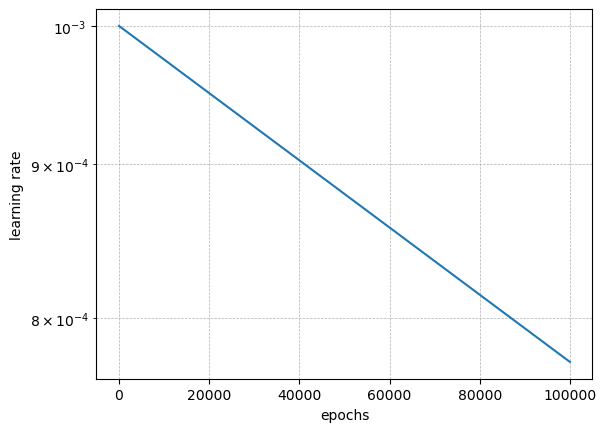

In [8]:
i = 1

ei = 0
ef = -1

# Plot in the second subplot
plt.semilogy(lr_list[ei:ef])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylabel("learning rate")
plt.xlabel("epochs")
#plt.ylabel(f"log(losses[{i}])")

#plt.savefig(f"./models/r_dom_fixed_omega_v3/loss_{i}.png", dpi=300, bbox_inches='tight')  # Save with high resolution


check values at r=0

In [9]:
Rmax = 1000
R0 = torch.zeros(1, requires_grad=True)#.to(device)

nn_sol_r01 = model1(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r02 = model2(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r03 = model3(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r04 = model4(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol_r05 = model5(R0)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot

nn_A1, alpha1, nn_chi_minus1, nn_phi1 = map(lambda i:  nn_sol_r01[[i]], range(4))
alphar1 = gradients(alpha1, R0)
A1 = 1 + R0*nn_A1/Rmax
chi1 = - R0*nn_chi_minus1/Rmax
phi1 = phi0 + R0*nn_phi1/Rmax
#
nn_A2, alpha2, nn_chi_minus2, nn_phi2 = map(lambda i:  nn_sol_r02[[i]], range(4))
alphar2 = gradients(alpha2, R0)
A2 = 1 + R0*nn_A2/Rmax
chi2 = - R0*nn_chi_minus2/Rmax
phi2 = phi0 + R0*nn_phi2/Rmax
#
nn_A3, alpha3, nn_chi_minus3, nn_phi3 = map(lambda i:  nn_sol_r03[[i]], range(4))
alphar3 = gradients(alpha3, R0)
A3= 1 + R0*nn_A3/Rmax
chi3 = - R0*nn_chi_minus3/Rmax
phi3 = phi0 + R0*nn_phi3/Rmax
#
nn_A4, alpha4, nn_chi_minus4, nn_phi4 = map(lambda i:  nn_sol_r04[[i]], range(4))
alphar4 = gradients(alpha4, R0)
A4 = 1 + R0*nn_A4/Rmax
chi4 = - R0*nn_chi_minus4/Rmax
phi4 = phi0 + R0*nn_phi4/Rmax
#
nn_A5, alpha5, nn_chi_minus5, nn_phi5 = map(lambda i:  nn_sol_r05[[i]], range(4))
alphar5 = gradients(alpha5, R0)
A5 = 1 + R0*nn_A5/Rmax
chi5 = - R0*nn_chi_minus5/Rmax
phi5 = phi0 + R0*nn_phi5/Rmax


print("A_nn_r01 =",A1.item())
print("A_nn_r02 =",A2.item())
print("A_nn_r03 =",A3.item())
print("A_nn_r04 =",A4.item())
print("A_nn_r05 =",A5.item())
print("A_r0    =",1)
print("")

print("alpha_nn_r01 =",alpha1.item())
print("alpha_nn_r02 =",alpha2.item())
print("alpha_nn_r03 =",alpha3.item())
print("alpha_nn_r04 =",alpha4.item())
print("alpha_nn_r05 =",alpha5.item())
print("alpha_r0    >",0)
print("")

print("chi_nn_r01 =",chi1.item())
print("chi_nn_r02 =",chi2.item())
print("chi_nn_r03 =",chi3.item())
print("chi_nn_r04 =",chi4.item())
print("chi_nn_r05 =",chi5.item())
print("chi_r0    =",0)
print("")

print("phi_nn_r01 =",phi1.item())
print("phi_nn_r02 =",phi2.item())
print("phi_nn_r03 =",phi3.item())
print("phi_nn_r04 =",phi4.item())
print("phi_nn_r05 =",phi5.item())
print("phi0_r0   =",phi0.item())
print("")

print("alphar_nn_r01 =",alphar1.item())
print("alphar_nn_r02 =",alphar2.item())
print("alphar_nn_r03 =",alphar3.item())
print("alphar_nn_r04 =",alphar4.item())
print("alphar_nn_r05 =",alphar5.item())
print("alphar_r0    =",0)

A_nn_r01 = 1.0
A_nn_r02 = 1.0
A_nn_r03 = 1.0
A_nn_r04 = 1.0
A_nn_r05 = 1.0
A_r0    = 1

alpha_nn_r01 = 0.6832987070083618
alpha_nn_r02 = 1.2249755859375
alpha_nn_r03 = 1.3131855726242065
alpha_nn_r04 = 1.3129491806030273
alpha_nn_r05 = 1.3080594539642334
alpha_r0    > 0

chi_nn_r01 = -0.0
chi_nn_r02 = -0.0
chi_nn_r03 = -0.0
chi_nn_r04 = -0.0
chi_nn_r05 = -0.0
chi_r0    = 0

phi_nn_r01 = 0.05000000074505806
phi_nn_r02 = 0.05000000074505806
phi_nn_r03 = 0.05000000074505806
phi_nn_r04 = 0.05000000074505806
phi_nn_r05 = 0.05000000074505806
phi0_r0   = 0.05000000074505806

alphar_nn_r01 = 1.781061291694641e-05
alphar_nn_r02 = 8.239177986979485e-06
alphar_nn_r03 = 9.983341442421079e-07
alphar_nn_r04 = 0.00010999908408848569
alphar_nn_r05 = 8.070492185652256e-08
alphar_r0    = 0


check values at training rmax

In [10]:
RMAX = 1000
rmax = RMAX*torch.ones(1, requires_grad=True)#.to(device)
nn_sol_rmax = model5(rmax)#.cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_A, alpha, nn_chi_minus, nn_phi = map(lambda i:  nn_sol_rmax[[i]], range(4))
alphar = gradients(alpha, rmax)
A = 1 + rmax*nn_A/RMAX
chi = - rmax*nn_chi_minus/RMAX
phi = phi0 + rmax*nn_phi/RMAX


print("A_nn_rmax =",A.item())
print("A_rmax    =",1)
print("")

print("alpha_nn_rmax =",alpha.item())
print("alpha_rmax    =",1)
print("")

print("chi_nn_rmax =",chi.item())
print("chi_rmax    =",0)
print("")

print("phi_nn_rmax =",phi.item())
print("phi0_rmax   =",0)

A_nn_rmax = 1.0
A_rmax    = 1

alpha_nn_rmax = 1.3081594705581665
alpha_rmax    = 1

chi_nn_rmax = -3.4004528082220986e-09
chi_rmax    = 0

phi_nn_rmax = 0.05000000074505806
phi0_rmax   = 0


get the solution of the nn for the exact r domain used by shooting

In [13]:
# the time domain; used to visualize the analytical solution
N = len(r) #1000
RMAX = r[-1]
R = torch.linspace(0,RMAX,N)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
RR = torch.linspace(0,RMAX,N).view(-1,1)#.to(device)

nn_sol1 = model1(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol2 = model2(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol3 = model3(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol4 = model4(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot
nn_sol5 = model5(RR).cpu().detach().numpy() # detach some extra info, and numpy makes a numpy array to plot

rr = RR.cpu().detach().numpy()

nn_A1, alpha1, nn_chi_minus1, nn_phi1 = map(lambda i:  nn_sol1[:,[i]], range(4))
A1 = 1 + rr*nn_A1/Rmax
chi1 = - rr*nn_chi_minus1/Rmax
phi1 = phi0 + rr*nn_phi1/Rmax
#
nn_A2, alpha2, nn_chi_minus2, nn_phi2 = map(lambda i:  nn_sol2[:,[i]], range(4))
A2 = 1 + rr*nn_A2/Rmax
chi2 = - rr*nn_chi_minus2/Rmax
phi2 = phi0 + rr*nn_phi2/Rmax
#
nn_A3, alpha3, nn_chi_minus3, nn_phi3 = map(lambda i:  nn_sol3[:,[i]], range(4))
A3= 1 + rr*nn_A3/Rmax
chi3 = - rr*nn_chi_minus3/Rmax
phi3 = phi0 + rr*nn_phi3/Rmax
#
nn_A4, alpha4, nn_chi_minus4, nn_phi4 = map(lambda i:  nn_sol4[:,[i]], range(4))
A4 = 1 + rr*nn_A4/Rmax
chi4 = - rr*nn_chi_minus4/Rmax
phi4 = phi0 + rr*nn_phi4/Rmax
#
nn_A5, alpha5, nn_chi_minus5, nn_phi5 = map(lambda i:  nn_sol5[:,[i]], range(4))
A5 = 1 + rr*nn_A5/Rmax
chi5 = - rr*nn_chi_minus5/Rmax
phi5 = phi0 + rr*nn_phi5/Rmax


/tmp/ipykernel_18903/3690558940.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi1 = phi0 + rr*nn_phi1/Rmax
/tmp/ipykernel_18903/3690558940.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi2 = phi0 + rr*nn_phi2/Rmax
/tmp/ipykernel_18903/3690558940.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi3 = phi0 + rr*nn_phi3/Rmax
/tmp/ipykernel_18903/3690558940.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  phi4 = phi0 + rr*nn_phi4/Rmax
/tmp/ipykernel_18903/3690558940.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.

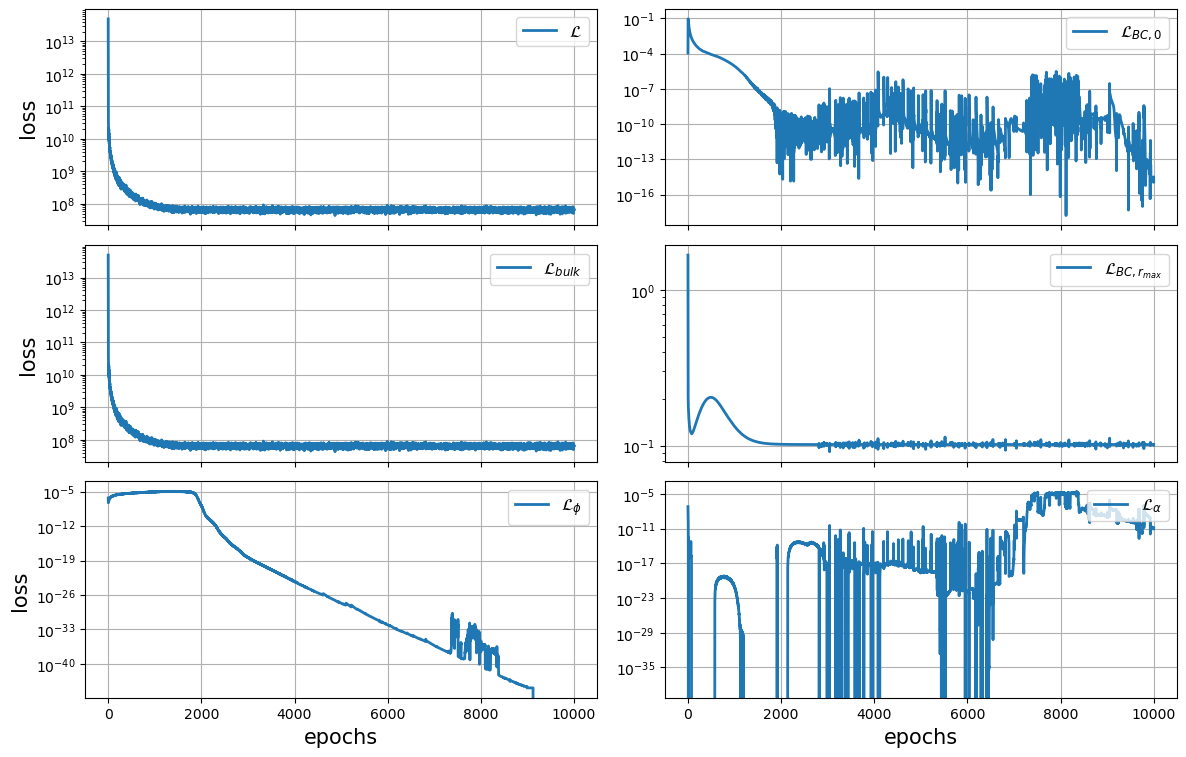

In [14]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12

step = 10

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# total loss

axs[0,0].plot(loss_list[0:-1:step], label=r"$\mathcal{L}$", lw=2, color="tab:blue",linestyle="-")
axs[0,0].set_yscale("log")
axs[0,0].grid(True)
axs[0,0].set_ylabel("loss", fontsize=l_size)
axs[0,0].legend(loc="upper right",fontsize=legend_fsize)
axs[0,0].set_xticklabels([])  # Remove x-axis tick labels

# loss at r0 (BC)

axs[0,1].plot(losses[0][0:-1:step], label=r"$\mathcal{L}_{BC,0}$", lw=2, color="tab:blue",linestyle="-")
axs[0,1].set_yscale("log")
axs[0,1].grid(True)
axs[0,1].set_xticklabels([])  # Remove x-axis tick labels
axs[0,1].legend(loc="upper right",fontsize=legend_fsize)
#axs[0,1].set_ylim(10**(-5),1)

# bulk loss

axs[1,0].plot(losses[1][0:-1:step], label=r"$\mathcal{L}_{bulk}$", lw=2, color="tab:blue",linestyle="-")
axs[1,0].set_yscale("log")
axs[1,0].grid(True)
axs[1,0].set_ylabel("loss", fontsize=l_size)
axs[1,0].set_xticklabels([])  # Remove x-axis tick label
axs[1,0].legend(loc="upper right",fontsize=legend_fsize)

# loss at rmax BC

axs[1,1].plot(losses[2][0:-1:step], label=r"$\mathcal{L}_{BC,r_{max}}$", lw=2, color="tab:blue",linestyle="-")
axs[1,1].set_yscale("log")
axs[1,1].grid(True)
axs[1,1].set_xticklabels([])  # Remove x-axis tick labels
axs[1,1].legend(loc="upper right",fontsize=legend_fsize)

# loss for phi monotonicity

axs[2,0].plot(losses[3][0:-1:step], label=r"$\mathcal{L}_{\phi}$", lw=2, color="tab:blue",linestyle="-")
axs[2,0].set_yscale("log")
axs[2,0].grid(True)
axs[2,0].set_ylabel("loss", fontsize=l_size)
axs[2,0].set_xlabel("epochs", fontsize=l_size)
axs[2,0].legend(loc="upper right",fontsize=legend_fsize)

# loss for alpha monotonicity

axs[2,1].plot(losses[4][0:-1:step], label=r"$\mathcal{L}_{\alpha}$", lw=2, color="tab:blue",linestyle="-")
axs[2,1].set_yscale("log")
axs[2,1].grid(True)
axs[2,1].set_xlabel("epochs", fontsize=l_size)
axs[2,1].legend(loc="upper right",fontsize=legend_fsize)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"losses.pdf")


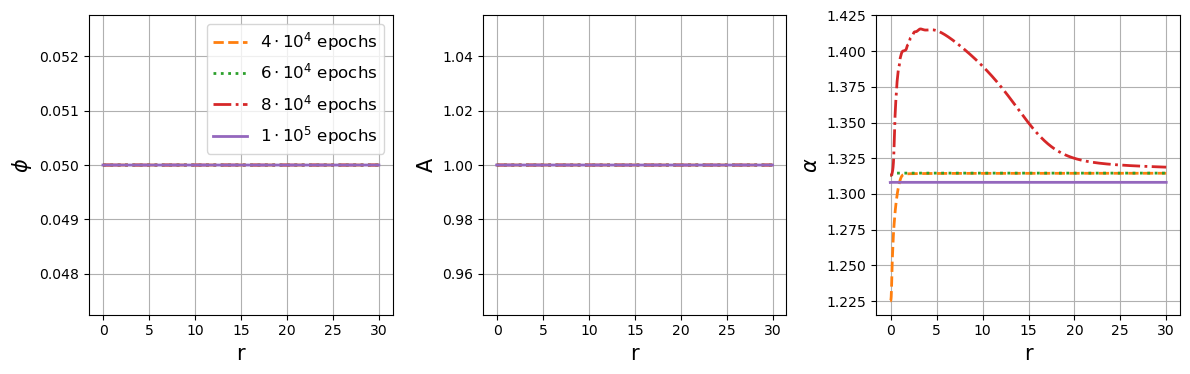

In [15]:
# title_fontsize
title_fsize = 22
# label
label_fsize = 19 # fontsize
l_size = 15 # labelsize
# legend_fsize
legend_fsize = 12


# Create subplots
fig, axs = plt.subplots(1,3, figsize=(12, 4))

# phi sols

#axs[0].plot(r, phi1, label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:blue",linestyle="-")
axs[0].plot(r, phi2, label=r"$4 \cdot 10^4$"+" epochs", lw=2, color="tab:orange",linestyle="--")
axs[0].plot(r, phi3, label=r"$6 \cdot 10^4$"+" epochs", lw=2, color="tab:green",linestyle=":")
axs[0].plot(r, phi4, label=r"$8 \cdot 10^4$"+" epochs", lw=2, color="tab:red",linestyle="-.")
axs[0].plot(r, phi5, label=r"$1 \cdot 10^5$"+" epochs", lw=2, color="tab:purple",linestyle="-")
#axs[0].plot(r, phi_shooting, label="shooting", lw=1.5, color="black",linestyle="--")
axs[0].grid(True)
axs[0].set_ylabel(r"$\phi$", fontsize=l_size)
axs[0].legend(loc="upper right",fontsize=legend_fsize)
#axs[0].set_xticklabels([])  # Remove x-axis tick label
axs[0].set_xlabel("r", fontsize=l_size)

# A sols
#axs[1].plot(r, A1, lw=2, color="tab:blue",linestyle="-")
axs[1].plot(r, A2, lw=2, color="tab:orange",linestyle="--")
axs[1].plot(r, A3, lw=2, color="tab:green",linestyle=":")
axs[1].plot(r, A4, lw=2, color="tab:red",linestyle="-.")
axs[1].plot(r, A5, lw=2, color="tab:purple",linestyle="-")
#axs[1].plot(r, A_shooting, lw=1.5, color="black",linestyle="--")
axs[1].grid(True)
axs[1].set_ylabel("A", fontsize=l_size)
#axs[1].set_xticklabels([])  # Remove x-axis tick label
axs[1].set_xlabel("r", fontsize=l_size)

# alpha sol
#axs[2].plot(r, alpha1, lw=2, color="tab:blue",linestyle="-")
axs[2].plot(r, alpha2, lw=2, color="tab:orange",linestyle="--")
axs[2].plot(r, alpha3, lw=2, color="tab:green",linestyle=":")
axs[2].plot(r, alpha4, lw=2, color="tab:red",linestyle="-.")
axs[2].plot(r, alpha5, lw=2, color="tab:purple",linestyle="-")
#axs[2].plot(r, alpha_shooting, lw=1.5, color="black",linestyle="--")
axs[2].grid(True)
axs[2].set_ylabel(r"$\alpha$", fontsize=l_size)
axs[2].set_xlabel("r", fontsize=l_size)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(out_dir+"solutions.pdf")
